# Telegram Activity Example

In [1]:
import os
import sys
import dotenv
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

In [2]:

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from client.query_api_client import QuantNoteQueryApi


## Create api client

In [3]:
dotenv.load_dotenv(".env")
AUTH_TOKEN = os.getenv("AUTH_TOKEN")
client = QuantNoteQueryApi(auth_token=AUTH_TOKEN, api_version="v1")
client

# Get telegram activity

In [4]:
query = """SELECT date_trunc('hour', created_at) as time, count(id) as count
FROM pubs.telegram.messages
where created_at >= timestamp '2023-01-20'
  and created_at <= timestamp '2023-01-31'
  and contains(tags, 'eth')
group by 1
order by 1;"""

response = client.get_data_response(query)
response['time'] = pd.to_datetime(response['time'])
response.set_index('time')
response

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,count,time
0,50,2023-01-20 00:00:00+00:00
1,44,2023-01-20 01:00:00+00:00
2,49,2023-01-20 02:00:00+00:00
3,38,2023-01-20 03:00:00+00:00
4,39,2023-01-20 04:00:00+00:00
...,...,...
259,165,2023-01-30 19:00:00+00:00
260,142,2023-01-30 20:00:00+00:00
261,127,2023-01-30 21:00:00+00:00
262,129,2023-01-30 22:00:00+00:00


# Plot telegram activity

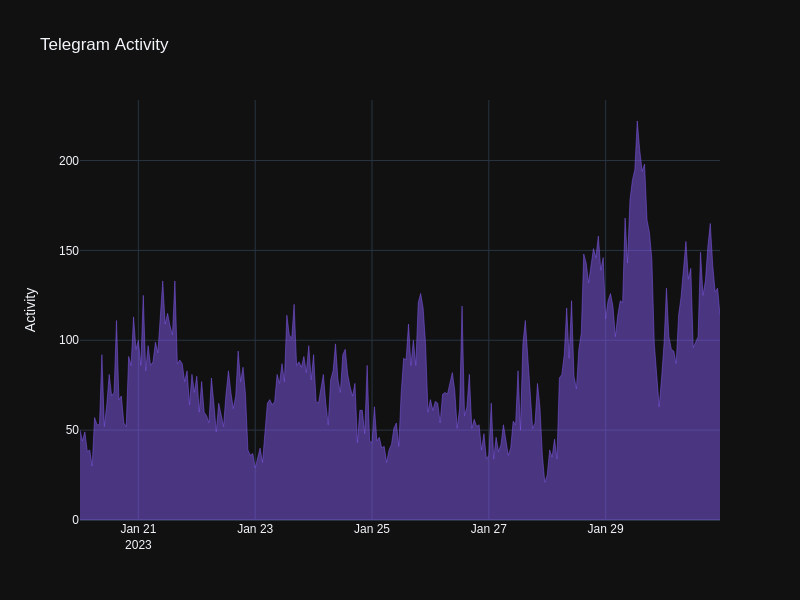

In [5]:
fig = go.Figure()

tg_activity = go.Scatter(x=response['time'],
                         y=response['count'],
                         name="tg activity",
                         mode='lines',
                         line=dict(width=0.5, color='rgb(131, 90, 241)'),
                         fill='tozeroy'
                         )

fig.add_trace(tg_activity)

fig.update_layout(
    width=800, height=600,
    title="Telegram Activity",
    xaxis_rangeslider_visible=False
)

# Set y-axes titles
fig.update_yaxes(title_text="Activity")

fig.show("png")


# Get TOHLCV

In [6]:
tohlcv_query = """SELECT p.bucket as time, open_stable, high_stable, low_stable, close_stable, v.volume
FROM series.chain_bsc.price_ticks_hourly p
         join series.chain_bsc.volume_ticks_hourly v
              on (p.bucket = v.bucket and p.token_id = v.token_id and p.platform_id = v.platform_id)
WHERE p.token_id = token('0x2170Ed0880ac9A755fd29B2688956BD959F933F8')
  and p.platform_id = 1
  and p.bucket > timestamp '2023-01-20'
  and p.bucket < timestamp '2023-01-31'
ORDER BY time;"""

tohlcv_resp = client.get_data_response(tohlcv_query)
tohlcv_resp['time'] = pd.to_datetime(tohlcv_resp['time'])
tohlcv_resp.set_index('time')
tohlcv_resp

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,close_stable,high_stable,low_stable,open_stable,time,volume
0,1553.2406879599641,1553.2406879599641,1548.0973573987842,1549.466760209362,2023-01-20 01:00:00+00:00,35.8655968864852715
1,1559.0305192434182,1559.8132887836807,1552.9475164048222,1553.636831518335,2023-01-20 02:00:00+00:00,32.2081217167854808
2,1555.2526614905266,1559.6976709615883,1554.7664862535646,1559.029867912009,2023-01-20 03:00:00+00:00,19.7631600203938278
3,1552.2500468449264,1560.5460281069527,1552.2500468449264,1555.2685686671673,2023-01-20 04:00:00+00:00,71.3861197839328803
4,1546.2929439129566,1552.3684273684719,1542.595494099532,1552.358911881794,2023-01-20 05:00:00+00:00,194.0519582954284757
...,...,...,...,...,...,...
258,1553.4530420279145,1580.9335810983528,1542.0742092846576,1580.9335810983528,2023-01-30 19:00:00+00:00,467.9038494501621417
259,1548.2315079791913,1554.3844596718839,1543.3713600912706,1553.5315526378265,2023-01-30 20:00:00+00:00,95.6188403102485219
260,1553.7810313614846,1561.0280278465432,1547.550427119921,1548.3106236739293,2023-01-30 21:00:00+00:00,72.6150913629695644
261,1560.3287482893447,1562.8974856948944,1551.2398223751059,1553.5664091479528,2023-01-30 22:00:00+00:00,180.0998666045632509


# Plot TOHCLV with Telegram Activity

In [7]:
tohlcv_resp['open_stable'] = pd.to_numeric(tohlcv_resp['open_stable'])
tohlcv_resp['high_stable'] = pd.to_numeric(tohlcv_resp['high_stable'])
tohlcv_resp['low_stable'] = pd.to_numeric(tohlcv_resp['low_stable'])
tohlcv_resp['close_stable'] = pd.to_numeric(tohlcv_resp['close_stable'])
tohlcv_resp

,close_stable,high_stable,low_stable,open_stable,time,volume
0,1553.240688,1553.240688,1548.097357,1549.466760,2023-01-20 01:00:00+00:00,35.8655968864852715
1,1559.030519,1559.813289,1552.947516,1553.636832,2023-01-20 02:00:00+00:00,32.2081217167854808
2,1555.252661,1559.697671,1554.766486,1559.029868,2023-01-20 03:00:00+00:00,19.7631600203938278
3,1552.250047,1560.546028,1552.250047,1555.268569,2023-01-20 04:00:00+00:00,71.3861197839328803
4,1546.292944,1552.368427,1542.595494,1552.358912,2023-01-20 05:00:00+00:00,194.0519582954284757
...,...,...,...,...,...,...
258,1553.453042,1580.933581,1542.074209,1580.933581,2023-01-30 19:00:00+00:00,467.9038494501621417
259,1548.231508,1554.384460,1543.371360,1553.531553,2023-01-30 20:00:00+00:00,95.6188403102485219
260,1553.781031,1561.028028,1547.550427,1548.310624,2023-01-30 21:00:00+00:00,72.6150913629695644
261,1560.328748,1562.897486,1551.239822,1553.566409,2023-01-30 22:00:00+00:00,180.0998666045632509


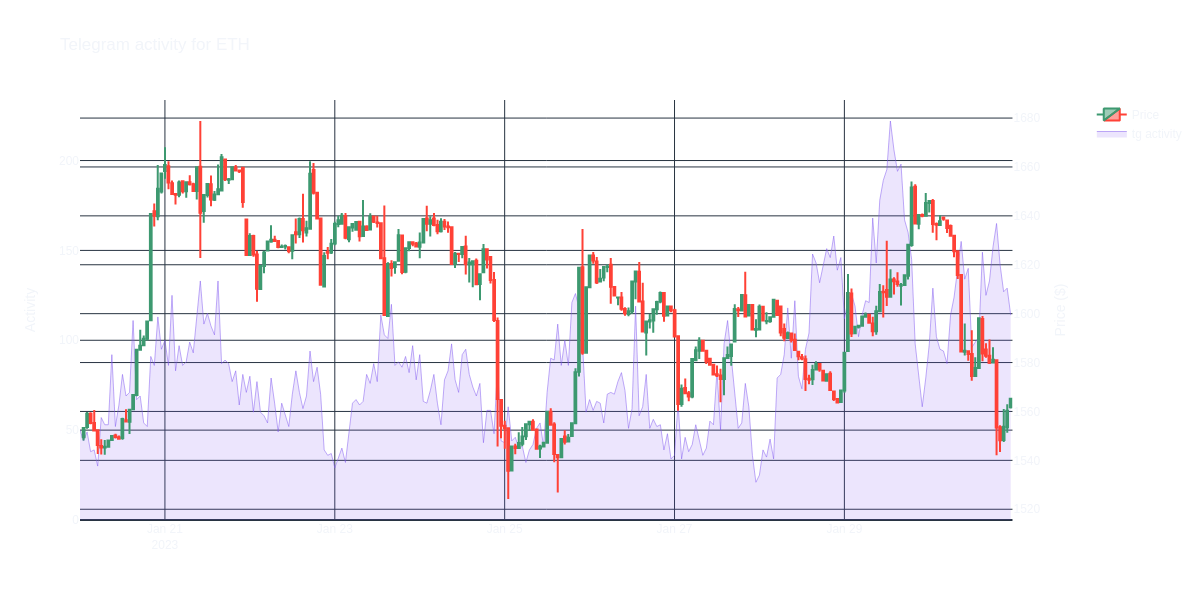

In [8]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

candlestick = go.Candlestick(
    x=tohlcv_resp['time'],
    open=tohlcv_resp['open_stable'],
    high=tohlcv_resp['high_stable'],
    low=tohlcv_resp['low_stable'],
    close=tohlcv_resp['close_stable'],
    name="Price"
)

tg_activity = go.Scatter(x=response['time'],
                         y=response['count'],
                         name="tg activity",
                         mode='lines',
                         line=dict(width=0.5, color='rgb(131, 90, 241)'),
                         fill='tozeroy',
                         fillcolor='rgba(131, 90, 241, 0.15)'
                         )

fig.add_trace(candlestick, secondary_y=True)
fig.add_trace(tg_activity, secondary_y=False)

fig.update_layout(
    width=1200, height=600,
    title="Telegram activity for ETH",
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis_rangeslider_visible=False
)

# Set y-axes titles
fig.update_yaxes(title_text="Activity", secondary_y=False)
fig.update_yaxes(title_text="Price ($)", secondary_y=True)

fig.show("png")

### Get Telegram sentiment

Obtain data from API

In [9]:
sent_query = """SELECT date_trunc('hour', created_at) as time, avg(emotion) as sentiment
FROM pubs.telegram.messages
where created_at >= timestamp '2023-01-20'
  and created_at <= timestamp '2023-01-31'
  and contains(tags, 'eth')
group by 1
order by 1;"""

sent = client.get_data_response(sent_query)

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

Some calculations and editing data
Calculate EMA

In [10]:
sent['time'] = pd.to_datetime(sent['time'])
sent.set_index('time')
sent['sentiment'] = pd.to_numeric(sent['sentiment'])
sent['ewm'] = sent['sentiment'].ewm(span=20,min_periods=0,adjust=False,ignore_na=False).mean()
sent

,sentiment,time,ewm
0,0.423476,2023-01-20 00:00:00+00:00,0.423476
1,0.363566,2023-01-20 01:00:00+00:00,0.417770
2,0.465602,2023-01-20 02:00:00+00:00,0.422326
3,0.389471,2023-01-20 03:00:00+00:00,0.419197
4,0.343779,2023-01-20 04:00:00+00:00,0.412014
...,...,...,...
259,0.456495,2023-01-30 19:00:00+00:00,0.545904
260,0.490652,2023-01-30 20:00:00+00:00,0.540642
261,0.507701,2023-01-30 21:00:00+00:00,0.537505
262,0.496974,2023-01-30 22:00:00+00:00,0.533645


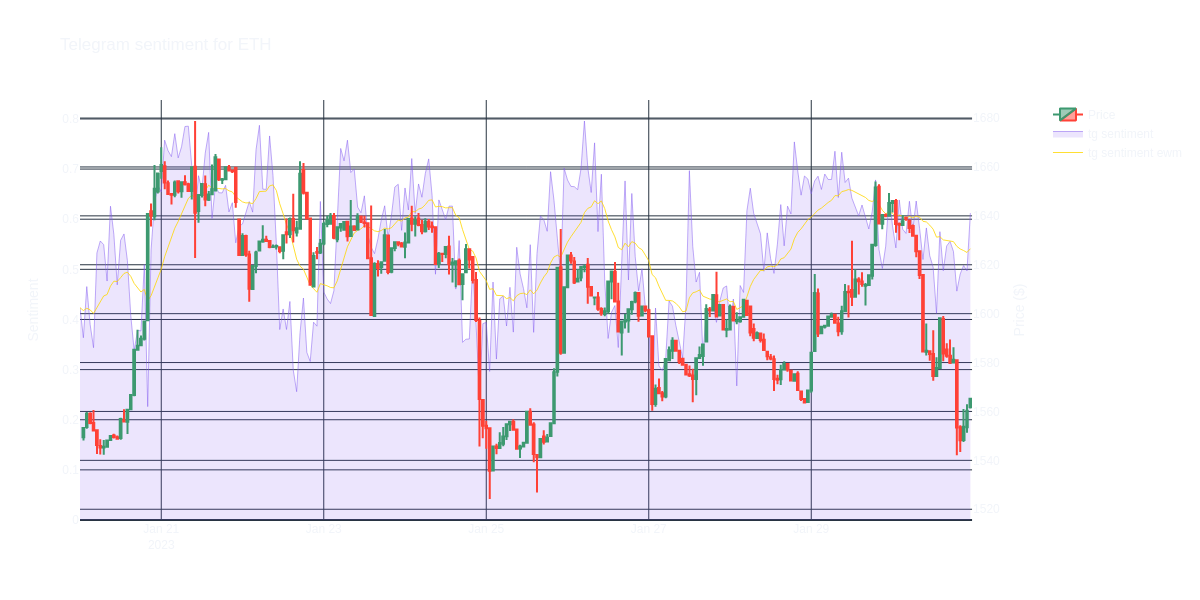

In [11]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

candlestick = go.Candlestick(
    x=tohlcv_resp['time'],
    open=tohlcv_resp['open_stable'],
    high=tohlcv_resp['high_stable'],
    low=tohlcv_resp['low_stable'],
    close=tohlcv_resp['close_stable'],
    name="Price"
)

tg_sentiment = go.Scatter(x=sent['time'],
                         y=sent['sentiment'],
                         name="tg sentiment",
                         mode='lines',
                         line=dict(width=0.5, color='rgb(131, 90, 241)'),
                         fill='tozeroy',
                         fillcolor='rgba(131, 90, 241, 0.15)'
                         )
tg_sentiment_ewm = go.Scatter(x=sent['time'],
                         y=sent['ewm'],
                         name="tg sentiment ewm",
                         mode='lines',
                         line=dict(width=0.8, color='gold')
                         )

fig.add_trace(candlestick, secondary_y=True)
fig.add_trace(tg_sentiment, secondary_y=False)
fig.add_trace(tg_sentiment_ewm, secondary_y=False)

fig.update_layout(
    width=1200, height=600,
    title="Telegram sentiment for ETH",
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis_rangeslider_visible=False
)

# Set y-axes titles
fig.update_yaxes(title_text="Sentiment", secondary_y=False)
fig.update_yaxes(title_text="Price ($)", secondary_y=True)

fig.show("png")